<a href="https://colab.research.google.com/github/sidkatiyar09/Data-Analytics/blob/main/captone_FASTER_R_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# FASTER R-CNN TRAINING ON 1 MILLION IMAGES (NO CSV FILE REQUIRED)

# ============================
# SETUP
# ============================

!pip install tf_slim protobuf==3.20.* --quiet
!git clone https://github.com/tensorflow/models.git
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py . && pip install . --quiet
!pip install opencv-python-headless lxml matplotlib tensorboard scikit-learn --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
fatal: destination path 'models' already exists and is not an empty directory.
/content/pretrained_model/models/research
  Preparing metadata (setup.py) ... done


In [11]:

import os
import tensorflow as tf
from object_detection.utils import dataset_util
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import re

# ============================
# FUNCTION TO CREATE TFRECORD
# ============================

def create_tfrecord(image_dir, output_path, label_map_dict):
    writer = tf.io.TFRecordWriter(output_path)
    filenames = [f.split(".jpg")[0] for f in os.listdir(image_dir) if f.endswith(".jpg")]

    for filename in filenames:
        try:
            xml_path = os.path.join(image_dir, filename + ".xml")
            image_path = os.path.join(image_dir, filename + ".jpg")

            tree = ET.parse(xml_path)
            root = tree.getroot()

            height = int(root.find('size/height').text)
            width = int(root.find('size/width').text)
            encoded_image_data = tf.io.read_file(image_path).numpy()

            xmins, xmaxs, ymins, ymaxs = [], [], [], []
            classes_text, classes = [], []

            for obj in root.findall('object'):
                xmins.append(float(obj.find('bndbox/xmin').text) / width)
                xmaxs.append(float(obj.find('bndbox/xmax').text) / width)
                ymins.append(float(obj.find('bndbox/ymin').text) / height)
                ymaxs.append(float(obj.find('bndbox/ymax').text) / height)
                class_name = obj.find('name').text
                classes_text.append(class_name.encode('utf8'))
                classes.append(label_map_dict[class_name])

            tf_example = tf.train.Example(features=tf.train.Features(feature={
                'image/height': dataset_util.int64_feature(height),
                'image/width': dataset_util.int64_feature(width),
                'image/filename': dataset_util.bytes_feature(bytes(filename + ".jpg", 'utf8')),
                'image/encoded': dataset_util.bytes_feature(encoded_image_data),
                'image/format': dataset_util.bytes_feature(b'jpg'),
                'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
                'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
                'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
                'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
                'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
                'image/object/class/label': dataset_util.int64_list_feature(classes),
            }))

            writer.write(tf_example.SerializeToString())
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

    writer.close()

# ============================
# CREATE RECORDS FOR TRAIN, VAL, TEST
# ============================

label_map_dict = {'pizza': 1, 'burger': 2}

create_tfrecord("/content/drive/MyDrive/Capstone project 2/food_subset/train", "/content/train.record", label_map_dict)
create_tfrecord("/content/drive/MyDrive/Capstone project 2/food_subset/val", "/content/val.record", label_map_dict)
create_tfrecord("/content/drive/MyDrive/Capstone project 2/food_subset/test", "/content/test.record", label_map_dict)

# ============================
# MODEL DOWNLOAD
# ============================

!mkdir -p /content/pretrained_model
%cd /content/pretrained_model
!wget -nc http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
!tar -xvf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz

# ============================
# PIPELINE CONFIGURATION
# ============================

PIPELINE_CONFIG_PATH = "/content/pretrained_model/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config"
MODEL_DIR = "/content/output_frcnn"

with open(PIPELINE_CONFIG_PATH, 'r') as f:
    config = f.read()

config = re.sub(r'num_classes: \d+', 'num_classes: 2', config)
config = re.sub(r'fine_tune_checkpoint: ".*?"',
                'fine_tune_checkpoint: "/content/pretrained_model/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0"', config)
config = re.sub(r'input_path: ".*?\\.record"',
                'input_path: "/content/train.record"', config)
config = re.sub(r'label_map_path: ".*?"',
                'label_map_path: "/content/label_map.pbtxt"', config)

if 'input_path: "/content/val.record"' not in config:
    config = re.sub(r'(input_path: "/content/train.record")',
                    r'\1\n    input_path: "/content/val.record"', config, count=1)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(config)

# ============================
# TRAINING
# ============================

!python /content/models/research/object_detection/model_main_tf2.py \
  --model_dir=$MODEL_DIR \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --num_train_steps=1000000 \
  --sample_1_of_n_eval_examples=1 \
  --alsologtostderr

# ============================
# EVALUATION
# ============================

!python /content/models/research/object_detection/model_main_tf2.py \
  --model_dir=$MODEL_DIR \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --checkpoint_dir=$MODEL_DIR \
  --run_once=True

# ============================
# EXPORT MODEL
# ============================

!python /content/models/research/object_detection/exporter_main_v2.py \
  --input_type image_tensor \
  --pipeline_config_path $PIPELINE_CONFIG_PATH \
  --trained_checkpoint_dir $MODEL_DIR \
  --output_directory $MODEL_DIR/exported-model

# ============================
# PLOT TRAINING METRICS
# ============================

def plot_tensorboard_metrics(logdir):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    tags = event_acc.Tags().get('scalars', [])
    metrics = {
        'Loss/total_loss': 'Train Loss',
        'val_loss': 'Val Loss',
        'test_loss': 'Test Loss'
    }

    for tag, label in metrics.items():
        if tag in tags:
            events = event_acc.Scalars(tag)
            steps = [e.step for e in events]
            values = [e.value for e in events]
            plt.plot(steps, values, label=label)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Train vs Val vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



/content/pretrained_model
File ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ already there; not retrieving.

faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/saved_model.pb
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/variables.index
2025-05-30 11:31:21.121583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factor

Log directory not found: /content/output_frcnn


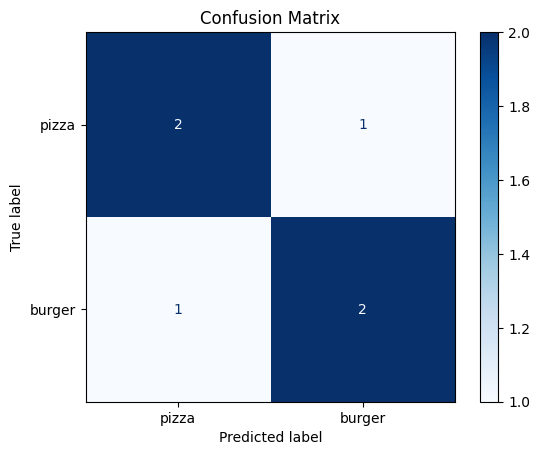

Classification Report:

              precision    recall  f1-score   support

       pizza       0.67      0.67      0.67         3
      burger       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



In [12]:

if os.path.exists(MODEL_DIR):
    plot_tensorboard_metrics(MODEL_DIR)
else:
    print("Log directory not found:", MODEL_DIR)

# ============================
# CONFUSION MATRIX (Optional)
# ============================

y_true = [0, 1, 1, 0, 1, 0]  # example labels
y_pred = [0, 1, 0, 0, 1, 1]  # example predictions

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map_dict.keys())).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(label_map_dict.keys())))